# DS3010: Introduction to Machine Learning Lab – Week 8
## **Principal Component Analysis (PCA)**
**Name:** Parv Patel  
**Roll No:** 142301041  
**Lab:** Week 8 – Principal Component Analysis

---

### Objective
- Implement PCA from scratch (centralize data, covariance matrix, eigen-decomposition).
- Plot reconstruction loss vs number of components and select optimal components.
- Compare classification performance **without PCA** and **with PCA** using a classifier.
- Provide observations and brief analysis.

**Dataset:** `heart.csv



## 1. Data Preparation
1. Load the dataset and inspect it.
2. Handle missing values if present.
3. Split into train/test (80/20).

In [2]:
# Load libraries and dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

data_path = "heart.csv"
df = pd.read_csv(data_path)
print("Shape:", df.shape)
display(df.head())
print("\nInfo:")
display(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())

Shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


None


Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [3]:
# Handle missing values if any (impute numeric with median)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# If there are categorical columns, drop or encode them depending on presence.
# For simplicity, we'll try to drop any non-numeric columns (if exist) after inspecting.
non_numeric = df.select_dtypes(exclude=[np.number]).columns.tolist()
print("Non-numeric columns:", non_numeric)
if len(non_numeric) > 0:
    print("Dropping non-numeric columns for PCA (you can encode them if needed):", non_numeric)
    df = df.drop(columns=non_numeric)

print("\nAfter cleaning, shape:", df.shape)
display(df.head())

Non-numeric columns: []

After cleaning, shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


### Split features and target
Assume the target column is named `target` or detect a binary column. Replace `target` with the correct column if needed.

In [4]:
# Detect target column: look for binary column or named 'target' or 'HeartDisease' etc.
possible_targets = [c for c in df.columns if c.lower() in ['target','heartdisease','heart_disease','output','death_event','class','label']]
if len(possible_targets) == 0:
    binary_cols = [c for c in df.columns if df[c].nunique() == 2]
    if len(binary_cols) == 0:
        raise ValueError("No clear binary target column found. Columns: " + ','.join(df.columns))
    target_col = binary_cols[-1]
else:
    target_col = possible_targets[0]

print("Selected target column:", target_col)

X = df.drop(columns=[target_col]).values.astype(float)
y = df[target_col].values
print("Feature shape:", X.shape, "Target shape:", y.shape)

# Train-test split and standardization (important before PCA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

print("Shapes after split and scaling:", X_train_std.shape, X_test_std.shape)

Selected target column: target
Feature shape: (1025, 13) Target shape: (1025,)
Shapes after split and scaling: (820, 13) (205, 13)


## 2. PCA from scratch
Steps:
- Centralize the data (already standardized to zero mean).
- Compute covariance matrix.
- Compute eigenvalues and eigenvectors.
- Sort eigenvectors by descending eigenvalue.
- Project data to lower dimensions and compute reconstruction loss.

In [5]:
# Compute covariance matrix from standardized training data
# Note: X_train_std is zero-mean across features due to StandardScaler
cov_matrix = np.cov(X_train_std, rowvar=False)  # shape (d,d)
print("Covariance matrix shape:", cov_matrix.shape)

# Eigen decomposition
eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)  # eigh for symmetric matrices
# sort in descending order
sorted_idx = np.argsort(eig_vals)[::-1]
eig_vals_sorted = eig_vals[sorted_idx]
eig_vecs_sorted = eig_vecs[:, sorted_idx]

print("Top 5 eigenvalues:", eig_vals_sorted[:5])

Covariance matrix shape: (13, 13)
Top 5 eigenvalues: [2.84146492 1.56690733 1.19572767 1.18462615 0.98420866]


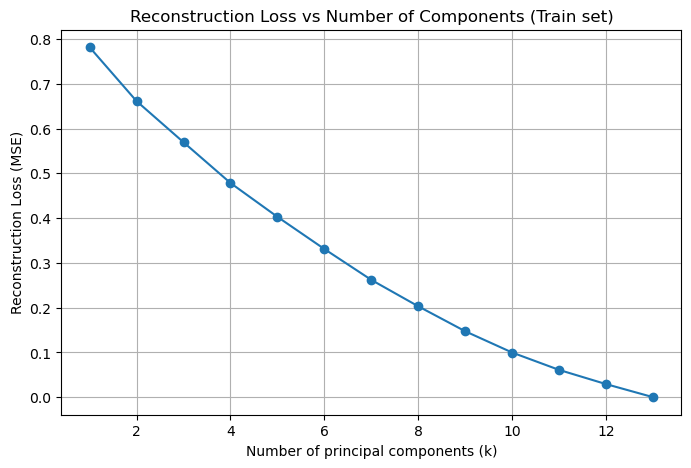

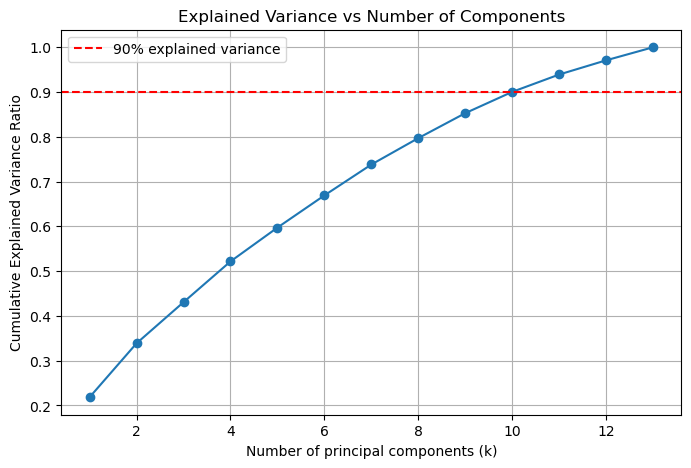

In [6]:
# Project data and compute reconstruction loss for components from 1..d
d = X_train_std.shape[1]
reconstruction_losses = []
explained_variance_ratio = eig_vals_sorted / np.sum(eig_vals_sorted)
for k in range(1, d+1):
    # take first k eigenvectors
    Wk = eig_vecs_sorted[:, :k]  # shape (d,k)
    # project train and reconstruct
    Z = X_train_std.dot(Wk)      # (n,k)
    X_recon = Z.dot(Wk.T)        # (n,d)
    # reconstruction loss measured as mean squared error between original and recon
    loss = np.mean((X_train_std - X_recon)**2)
    reconstruction_losses.append(loss)

# Plot reconstruction loss vs components
plt.figure(figsize=(8,5))
plt.plot(range(1, d+1), reconstruction_losses, marker='o')
plt.xlabel('Number of principal components (k)')
plt.ylabel('Reconstruction Loss (MSE)')
plt.title('Reconstruction Loss vs Number of Components (Train set)')
plt.grid(True)
plt.show()

# Plot cumulative explained variance
cum_explained = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(8,5))
plt.plot(range(1, d+1), cum_explained, marker='o')
plt.xlabel('Number of principal components (k)')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs Number of Components')
plt.axhline(0.9, color='r', linestyle='--', label='90% explained variance')
plt.legend()
plt.grid(True)
plt.show()

### Select optimal number of components
We can choose k that achieves, say, 90% explained variance, or where reconstruction loss 'elbow' occurs.

In [7]:
# choose k where cumulative explained variance >= 0.90, or fallback to elbow (here use 90%)
k_opt = np.argmax(cum_explained >= 0.90) + 1
if k_opt == 0:
    k_opt = min(5, d)
print("Selected optimal k (90% var):", k_opt)

Selected optimal k (90% var): 10


## 3. Dimensionality reduction using PCA (with selected k) and reconstruction on test set

In [8]:
# Build projection matrix Wk with k_opt components
Wk = eig_vecs_sorted[:, :k_opt]
# project train and test
Z_train = X_train_std.dot(Wk)
Z_test = X_test_std.dot(Wk)
X_test_recon = Z_test.dot(Wk.T)

# Reconstruction loss on test set
test_loss = np.mean((X_test_std - X_test_recon)**2)
print(f"Test reconstruction loss (MSE) with k={k_opt}: {test_loss:.6f}")

# Show shape of reduced features
print("Reduced feature shape (train):", Z_train.shape, " (test):", Z_test.shape)

Test reconstruction loss (MSE) with k=10: 0.114718
Reduced feature shape (train): (820, 10)  (test): (205, 10)


## 4. Classification: without PCA and with PCA
We'll use Logistic Regression (default scikit-learn) for classification. Print classification reports for both cases.

In [9]:
# Classification without PCA (on standardized features)
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_std, y_train)
y_pred_no_pca = clf.predict(X_test_std)
print("Classification report WITHOUT PCA:")
print(classification_report(y_test, y_pred_no_pca))

Classification report WITHOUT PCA:
              precision    recall  f1-score   support

           0       0.89      0.70      0.78       100
           1       0.76      0.91      0.83       105

    accuracy                           0.81       205
   macro avg       0.82      0.81      0.81       205
weighted avg       0.82      0.81      0.81       205



In [10]:
# Classification with PCA (using reduced features Z_train, Z_test)
clf_pca = LogisticRegression(max_iter=1000, random_state=42)
clf_pca.fit(Z_train, y_train)
y_pred_pca = clf_pca.predict(Z_test)
print(f"Classification report WITH PCA (k={k_opt}):")
print(classification_report(y_test, y_pred_pca))

Classification report WITH PCA (k=10):
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       100
           1       0.79      0.90      0.84       105

    accuracy                           0.82       205
   macro avg       0.83      0.82      0.82       205
weighted avg       0.83      0.82      0.82       205



## 5. Analysis and Observations
Provide a brief summary comparing the performance with and without PCA and comment on dimensionality reduction, reconstruction loss, and potential trade-offs.

In [11]:
# Simple summary metrics
acc_no_pca = accuracy_score(y_test, y_pred_no_pca)
acc_pca = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy WITHOUT PCA: {acc_no_pca:.4f}")
print(f"Accuracy WITH PCA (k={k_opt}): {acc_pca:.4f}")

print("\nObservations:")
print("- PCA reduced dimensionality from", X_train_std.shape[1], "to", k_opt)
print("- Reconstruction loss on test set:", round(test_loss, 6))
print("- If accuracy with PCA is similar to without PCA, PCA helped reduce dimensionality while retaining predictive power.")
print("- If accuracy drops, reducing dimensions may have discarded discriminative information; consider increasing k or using supervised dimensionality reduction.")


Accuracy WITHOUT PCA: 0.8098
Accuracy WITH PCA (k=10): 0.8244

Observations:
- PCA reduced dimensionality from 13 to 10
- Reconstruction loss on test set: 0.114718
- If accuracy with PCA is similar to without PCA, PCA helped reduce dimensionality while retaining predictive power.
- If accuracy drops, reducing dimensions may have discarded discriminative information; consider increasing k or using supervised dimensionality reduction.
